In [1]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import MySQLdb
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import datetime

In [26]:
conn = MySQLdb.connect(host="localhost", user="root", passwd="", db="iot")
cursor = conn.cursor()
#cursor.execute('select time, source, destination, protocol, type, size from ip limit 250');
#cursor.execute('SELECT time, sum(size) as size FROM ip WHERE time >="2018-03-08 12:38:00" AND time <"2018-03-08 12:48:00" group by time')
cursor.execute('SELECT time, size FROM ip WHERE time >="2018-03-08 12:38:00" AND time <"2018-03-08 12:48:00"') #chromecast

rows = cursor.fetchall()

cursor.execute('SELECT time, size FROM ip WHERE time >="2018-11-10 7:22:00" AND time <"2018-11-10 7:32:00"') #google home

rows2 = cursor.fetchall()

#cursor.execute('SELECT time, size FROM ip WHERE time >="2018-04-17 6:02:00" AND time <"2018-04-17 6:42:00"') #xbox
#cursor.execute('SELECT time, size FROM ip WHERE time >="2018-04-19 3:54:00" AND time <"2018-04-19 4:50:00"') #xbox
#cursor.execute('SELECT time, size FROM ip WHERE time >="2018-04-26 1:24:00" AND time <"2018-04-26 1:34:00"') #chromecast, tv
#cursor.execute('SELECT time, size FROM ip WHERE time >="2018-04-26 4:05:00" AND time <"2018-04-26 4:30:00"') #xbox
cursor.execute('SELECT time, size FROM ip WHERE time >="2018-05-10 5:40:00" AND time <"2018-05-10 5:59:00"') #xbox

rows_xbox = cursor.fetchall()

cursor.execute('SELECT time, size FROM ip WHERE time >="2018-04-17 5:37:00" AND time <"2018-04-17 5:40:00"') #all reconnected
#cursor.execute('SELECT time, size FROM ip WHERE time >="2018-05-01 5:45:00" AND time <"2018-05-01 6:45:00"') #all 


rows_all = cursor.fetchall()


In [27]:
df = pd.DataFrame( [[ij for ij in i] for i in rows] )
df2 = pd.DataFrame( [[ij for ij in i] for i in rows2] )
df_xbox = pd.DataFrame( [[ij for ij in i] for i in rows_xbox] )
df_all = pd.DataFrame( [[ij for ij in i] for i in rows_all] )
df2.rename(columns={0: 'Time', 1: 'Size'}, inplace=True);
df.rename(columns={0: 'Time', 1: 'Size'}, inplace=True)
df_xbox.rename(columns={0: 'Time', 1: 'Size'}, inplace=True)
df_all.rename(columns={0: 'Time', 1: 'Size'}, inplace=True)
df['Size'] = pd.to_numeric(df['Size'])
df2['Size'] = pd.to_numeric(df2['Size'])
df_xbox['Size'] = pd.to_numeric(df_xbox['Size'])
df_all['Size'] = pd.to_numeric(df_all['Size'])
df.info()
chromecast_packets_df = df
google_home_packets_df = df2
xbox_packets_df = df_xbox
all_packets_df = df_all
df = df.groupby(['Time']).sum().reset_index()
df2 = df2.groupby(['Time']).sum().reset_index()
df_xbox = df_xbox.groupby(['Time']).sum().reset_index()
df_all = df_all.groupby(['Time']).sum().reset_index()
df.head()
#df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 2 columns):
Time    4754 non-null datetime64[ns]
Size    4754 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 74.4 KB


,Time,Size
0,2018-03-08 12:38:00,126
1,2018-03-08 12:38:01,1276
2,2018-03-08 12:38:02,1374
3,2018-03-08 12:38:03,690
4,2018-03-08 12:38:05,460


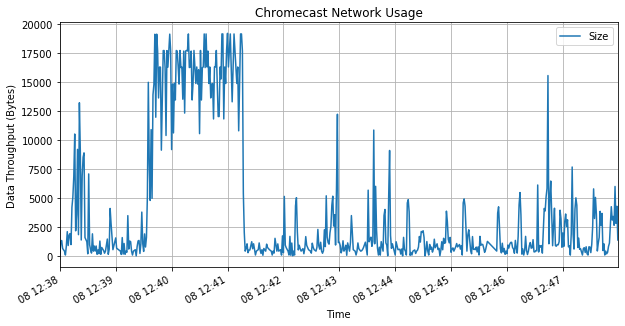

In [69]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

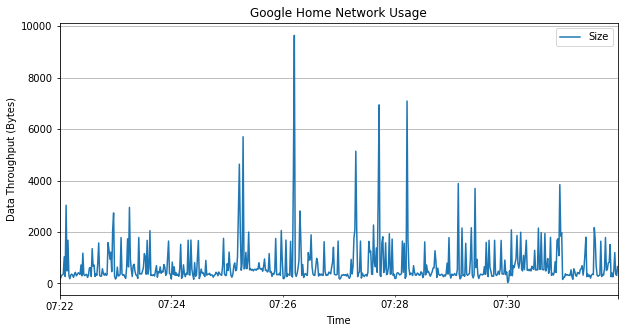

In [25]:
ax = df2.plot(x='Time', y='Size', kind='line', grid=True, title='Google Home Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

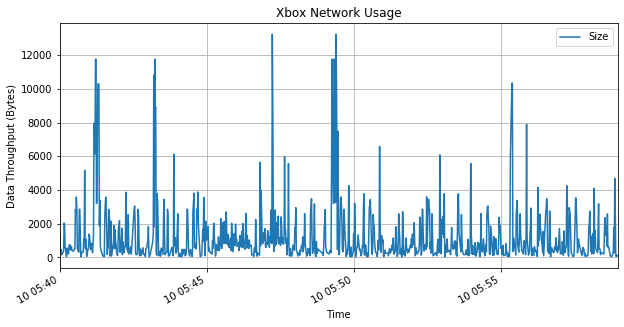

In [13]:
ax = df_xbox.plot(x='Time', y='Size', kind='line', grid=True, title='Xbox Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

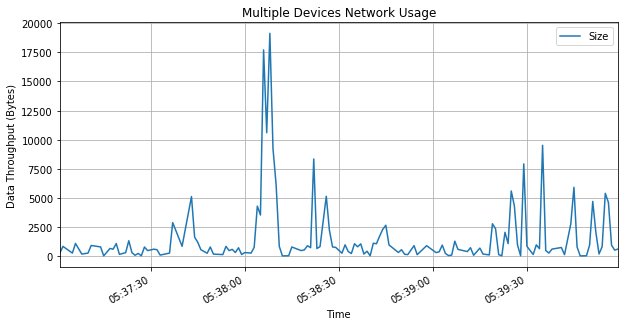

In [28]:
ax = df_all.plot(x='Time', y='Size', kind='line', grid=True, title='Multiple Devices Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

In [30]:
def ilp_constant_alg(input_df, constant_rate):
    output_df = pd.DataFrame(columns=['Time', 'Size'])
    stats = {'max_delay' : 0, 'num_packets_delayed' : 0, 'total_padding' : 0, 'num_times_padded' : 0}
    padding = 0
    delayed_time = 0
    current_size = 0
    current_time = 0
    delayed_packets = []
    for index in range(len(input_df)):
        t = input_df['Time'].iloc[index]
        s = input_df['Size'].iloc[index]
        if t != current_time:
            if current_size < constant_rate and current_time != 0:
                padding = constant_rate - current_size
                output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
                stats['total_padding'] += padding
                stats['num_times_padded'] += 1
            current_time = t
            current_size = 0
        pop_count = 0
        for dt, ds in delayed_packets:
            if ds + current_size <= constant_rate:
                current_size += ds
                output_df = output_df.append({'Time': current_time, 'Size': ds}, ignore_index=True)
                delayed_time = (current_time - dt).total_seconds()
                if delayed_time > stats['max_delay']:
                    stats['max_delay'] = delayed_time
                pop_count += 1
            else:
                break
        for i in range(pop_count):
            delayed_packets.pop(0)
        if s + current_size <= constant_rate:
            output_df = output_df.append({'Time': t, 'Size': s}, ignore_index=True)
            current_size += s
        else:
            delayed_packets.append((t,s))
            stats['num_packets_delayed'] += 1
    if current_size < constant_rate and current_time != 0:
            padding = constant_rate - current_size
            output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
            stats['total_padding'] += padding
            stats['num_times_padded'] += 1
    return output_df, stats

In [31]:
chromecast_ilp_const_df, chromecast_ilp_const_stats = ilp_constant_alg(chromecast_packets_df, 10000)
chromecast_ilp_const_df = chromecast_ilp_const_df.groupby(['Time']).sum().reset_index()
chromecast_ilp_const_df.head()

,Time,Size
0,2018-03-08 12:38:00,10000
1,2018-03-08 12:38:01,10000
2,2018-03-08 12:38:02,10000
3,2018-03-08 12:38:03,10000
4,2018-03-08 12:38:05,10000


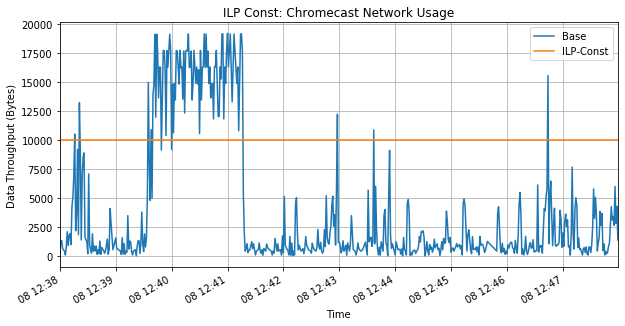

In [32]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
chromecast_ilp_const_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Const: Chromecast Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'ILP-Const'])
plt.show()

In [33]:
print ("Stats : total_user_packets :", df['Size'].sum())
for stat in chromecast_ilp_const_stats:
    print("Stats : {} : {}".format(stat,chromecast_ilp_const_stats[stat]))

Stats : total_user_packets : 2325377
Stats : max_delay : 87.0
Stats : num_packets_delayed : 1127
Stats : total_padding : 3224623
Stats : num_times_padded : 555


In [37]:
google_home_ilp_const_df, google_home_ilp_const_stats = ilp_constant_alg(google_home_packets_df, 5000)
google_home_ilp_const_df = google_home_ilp_const_df.groupby(['Time']).sum().reset_index()
google_home_ilp_const_df.head()

,Time,Size
0,2018-11-10 07:22:00,5000
1,2018-11-10 07:22:01,5000
2,2018-11-10 07:22:02,5000
3,2018-11-10 07:22:03,5000
4,2018-11-10 07:22:04,5000


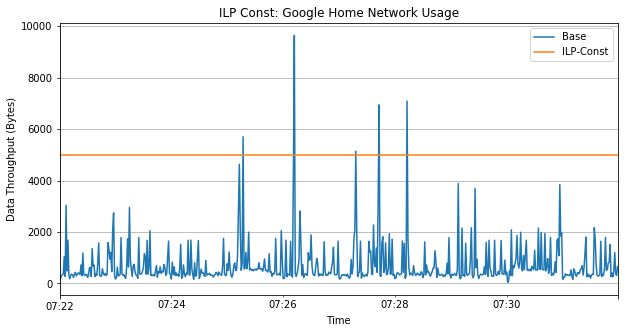

In [38]:
ax = df2.plot(x='Time', y='Size', kind='line', grid=True, title='Google Home Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
google_home_ilp_const_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Const: Google Home Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'ILP-Const'])
plt.show()

In [39]:
print ("Stats : total_user_packets :", df2['Size'].sum())
for stat in google_home_ilp_const_stats:
    print("Stats : {} : {}".format(stat,google_home_ilp_const_stats[stat]))

Stats : total_user_packets : 427735
Stats : max_delay : 2.0
Stats : num_packets_delayed : 15
Stats : total_padding : 2572265
Stats : num_times_padded : 600


In [40]:
xbox_ilp_const_df, xbox_ilp_const_stats = ilp_constant_alg(xbox_packets_df, 6000)
xbox_ilp_const_df = xbox_ilp_const_df.groupby(['Time']).sum().reset_index()
xbox_ilp_const_df.head()

,Time,Size
0,2018-05-10 05:40:00,6000
1,2018-05-10 05:40:01,6000
2,2018-05-10 05:40:03,6000
3,2018-05-10 05:40:04,6000
4,2018-05-10 05:40:05,6000


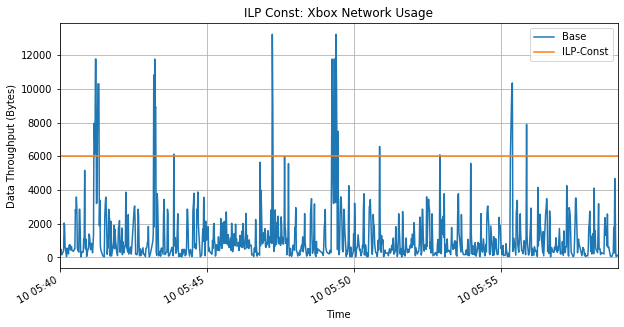

In [41]:
ax = df_xbox.plot(x='Time', y='Size', kind='line', grid=True, title='Xbox Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
xbox_ilp_const_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Const: Xbox Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'ILP-Const'])
plt.show()

In [42]:
print ("Stats : total_user_packets :", df_xbox['Size'].sum())
for stat in xbox_ilp_const_stats:
    print("Stats : {} : {}".format(stat,xbox_ilp_const_stats[stat]))

Stats : total_user_packets : 1229435
Stats : max_delay : 10.0
Stats : num_packets_delayed : 274
Stats : total_padding : 4452565
Stats : num_times_padded : 946


In [44]:
def ilp_variable_alg(input_df, min_rate, max_rate):
    output_df = pd.DataFrame(columns=['Time', 'Size'])
    stats = {'max_delay' : 0, 'num_packets_delayed' : 0, 'total_padding' : 0, 'num_times_padded' : 0}
    padding = 0
    delayed_time = 0
    current_size = 0
    current_time = 0
    delayed_packets = []
    current_rate = 0
    for index in range(len(input_df)):
        t = input_df['Time'].iloc[index]
        s = input_df['Size'].iloc[index]
        if t != current_time:
            if current_size < current_rate and current_time != 0:
                padding = current_rate - current_size
                output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
                stats['total_padding'] += padding
                stats['num_times_padded'] += 1
            current_time = t
            current_size = 0
            current_rate = random.randint(min_rate, max_rate)
        pop_count = 0
        for dt, ds in delayed_packets:
            if ds + current_size <= current_rate:
                current_size += ds
                output_df = output_df.append({'Time': current_time, 'Size': ds}, ignore_index=True)
                delayed_time = (current_time - dt).total_seconds()
                if delayed_time > stats['max_delay']:
                    stats['max_delay'] = delayed_time
                pop_count += 1
            else:
                break
        for i in range(pop_count):
            delayed_packets.pop(0)
        if s + current_size <= current_rate:
            output_df = output_df.append({'Time': t, 'Size': s}, ignore_index=True)
            current_size += s
        else:
            delayed_packets.append((t,s))
            stats['num_packets_delayed'] += 1
    if current_size < current_rate and current_time != 0:
            padding = current_rate - current_size
            output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
            stats['total_padding'] += padding
            stats['num_times_padded'] += 1
    return output_df, stats

In [45]:
chromecast_ilp_var_df, chromecast_ilp_var_stats = ilp_variable_alg(chromecast_packets_df, 1000, 10000)
chromecast_ilp_var_df = chromecast_ilp_var_df.groupby(['Time']).sum().reset_index()
chromecast_ilp_var_df.head()

,Time,Size
0,2018-03-08 12:38:00,8117
1,2018-03-08 12:38:01,2286
2,2018-03-08 12:38:02,7956
3,2018-03-08 12:38:03,5817
4,2018-03-08 12:38:05,5618


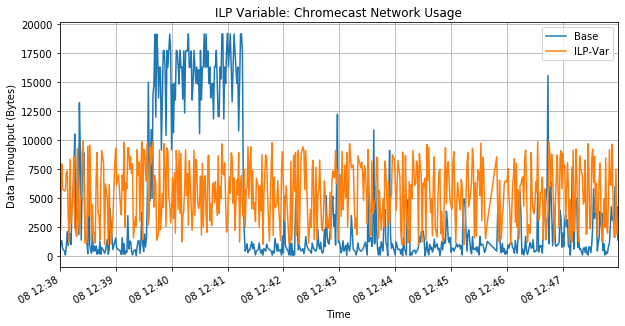

In [46]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
chromecast_ilp_var_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Variable: Chromecast Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'ILP-Var'])
plt.show()

In [47]:
for stat in chromecast_ilp_var_stats:
    print("Stats : {} : {}".format(stat,chromecast_ilp_var_stats[stat]))

Stats : max_delay : 254.0
Stats : num_packets_delayed : 2188
Stats : total_padding : 694165
Stats : num_times_padded : 554


In [38]:
google_home_ilp_var_df, google_home_ilp_var_stats = ilp_variable_alg(google_home_packets_df, int(df2['Size'].mean()-df2['Size'].std()), int(df2['Size'].mean()+df2['Size'].std()))
google_home_ilp_var_df = google_home_ilp_var_df.groupby(['Time']).sum().reset_index()
google_home_ilp_var_df.head()

,Time,Size
0,2018-11-10 07:22:00,297
1,2018-11-10 07:22:01,311
2,2018-11-10 07:22:02,1130
3,2018-11-10 07:22:03,333
4,2018-11-10 07:22:04,1471


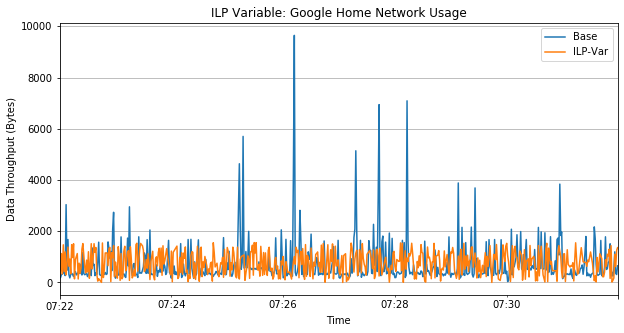

In [54]:
ax = df2.plot(x='Time', y='Size', kind='line', grid=True, title='Google Home Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
google_home_ilp_var_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Variable: Google Home Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'ILP-Var'])
plt.show()

In [40]:
for stat in google_home_ilp_var_stats:
    print("Stats : {} : {}".format(stat,google_home_ilp_var_stats[stat]))

Stats : max_delay : 273.0
Stats : num_packets_delayed : 2482
Stats : total_padding : 122614
Stats : num_times_padded : 539


In [12]:
xbox_ilp_var_df, xbox_ilp_var_stats = ilp_variable_alg(xbox_packets_df, int(df_xbox['Size'].mean()-df_xbox['Size'].std()), int(df_xbox['Size'].mean()+df_xbox['Size'].std()))
xbox_ilp_var_df = xbox_ilp_var_df.groupby(['Time']).sum().reset_index()
xbox_ilp_var_df.head()

,Time,Size
0,2018-05-10 05:40:00,825
1,2018-05-10 05:40:01,167
2,2018-05-10 05:40:03,2220
3,2018-05-10 05:40:04,2882
4,2018-05-10 05:40:05,2651


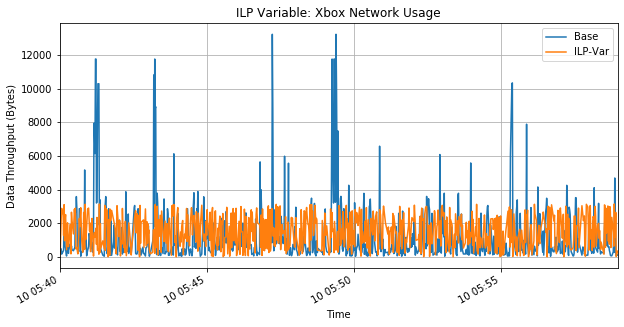

In [13]:
ax = df_xbox.plot(x='Time', y='Size', kind='line', grid=True, title='Xbox Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
xbox_ilp_var_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Variable: Xbox Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'ILP-Var'])
plt.show()

In [14]:
for stat in xbox_ilp_var_stats:
    print("Stats : {} : {}".format(stat,xbox_ilp_var_stats[stat]))

Stats : max_delay : 295.0
Stats : num_packets_delayed : 3135
Stats : total_padding : 180381
Stats : num_times_padded : 811


In [15]:
def stp_alg(input_df, R, q, threshold):
    output_df = pd.DataFrame(columns=['Time', 'Size'])
    stats = {'max_delay' : 0, 'num_packets_delayed' : 0, 'total_padding' : 0, 'num_times_padded' : 0}
    T = 10 #Time period length in sec
    padStart = 0
    padEnd = 0
    padOffset = 0
    current_time = input_df['Time'].iloc[0]
    totalTime = int((input_df['Time'].iloc[len(input_df)-1] - current_time).total_seconds())
    for t in range(totalTime):
        if t % T == 0 and random.random() < q:
            padOffset = random.randint(0, T)
            if t + padOffset > padEnd:
                padStart = t + padOffset
                padEnd = padStart + T
            else:
                padEnd = padEnd + T
        temp_df = input_df[input_df['Time']==current_time]['Size']
        if t >= padStart and t <= padEnd:
            stats['num_times_padded'] += 1
            if temp_df.size > 0:
                s = temp_df.iloc[0]
                stats['total_padding'] += R - s
            else:
                stats['total_padding'] += R
            output_df = output_df.append({'Time': current_time, 'Size': R}, ignore_index=True)
        elif temp_df.size > 0:
            s = temp_df.iloc[0]
            if s > threshold:
                padStart = t
                padEnd = t + T
                stats['num_times_padded'] += 1
                stats['total_padding'] += R - s
                output_df = output_df.append({'Time': current_time, 'Size': R}, ignore_index=True)
            else:
                output_df = output_df.append({'Time': current_time, 'Size': s}, ignore_index=True)
        current_time = current_time + datetime.timedelta(seconds=1)
    return output_df, stats

In [42]:
chromecast_stp_df, chromecast_stp_stats = stp_alg(df, int(df['Size'].max()), 0.15, 7500)
chromecast_stp_df.head()

,Time,Size
0,2018-03-08 12:38:00,126
1,2018-03-08 12:38:01,1276
2,2018-03-08 12:38:02,19188
3,2018-03-08 12:38:03,19188
4,2018-03-08 12:38:04,19188


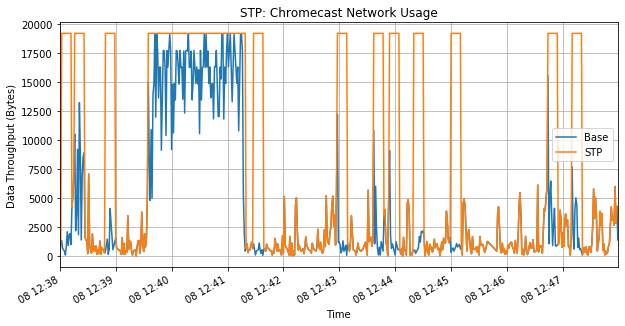

In [55]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
chromecast_stp_df.plot(x='Time', y='Size', kind='line', grid=True, title='STP: Chromecast Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'STP'])
plt.show()

In [44]:
for stat in chromecast_stp_stats:
    print("Stats : {} : {}".format(stat,chromecast_stp_stats[stat]))

Stats : max_delay : 0
Stats : num_packets_delayed : 0
Stats : total_padding : 2494334
Stats : num_times_padded : 226


In [17]:
google_home_stp_df, google_home_stp_stats = stp_alg(df2, int(df2['Size'].max()), 0.15, 4000)
google_home_stp_df.head()

,Time,Size
0,2018-11-10 07:22:00,9646
1,2018-11-10 07:22:01,188
2,2018-11-10 07:22:02,304
3,2018-11-10 07:22:03,328
4,2018-11-10 07:22:04,363


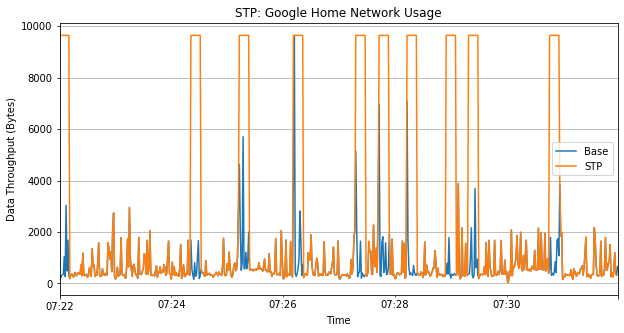

In [56]:
ax = df2.plot(x='Time', y='Size', kind='line', grid=True, title='Google Home Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
google_home_stp_df.plot(x='Time', y='Size', kind='line', grid=True, title='STP: Google Home Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'STP'])
plt.show()

In [47]:
for stat in google_home_stp_stats:
    print("Stats : {} : {}".format(stat,google_home_stp_stats[stat]))

Stats : max_delay : 0
Stats : num_packets_delayed : 0
Stats : total_padding : 940064
Stats : num_times_padded : 110


In [18]:
xbox_stp_df, xbox_stp_stats = stp_alg(df_xbox, int(df_xbox['Size'].max()), 0.15, 6000)
xbox_stp_df.head()

,Time,Size
0,2018-05-10 05:40:00,13230
1,2018-05-10 05:40:01,392
2,2018-05-10 05:40:03,479
3,2018-05-10 05:40:04,162
4,2018-05-10 05:40:05,212


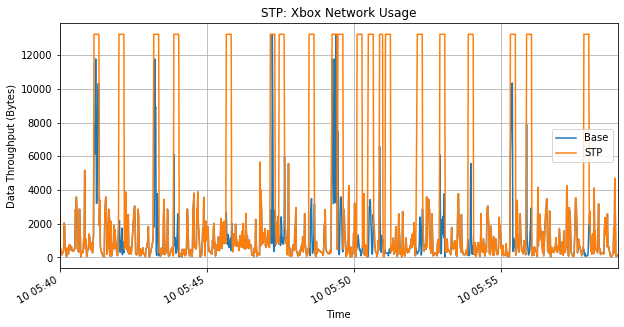

In [19]:
ax = df_xbox.plot(x='Time', y='Size', kind='line', grid=True, title='Xbox Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
xbox_stp_df.plot(x='Time', y='Size', kind='line', grid=True, title='STP: Xbox Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'STP'])
plt.show()

In [20]:
for stat in xbox_stp_stats:
    print("Stats : {} : {}".format(stat,xbox_stp_stats[stat]))

Stats : max_delay : 0
Stats : num_packets_delayed : 0
Stats : total_padding : 2360997
Stats : num_times_padded : 216


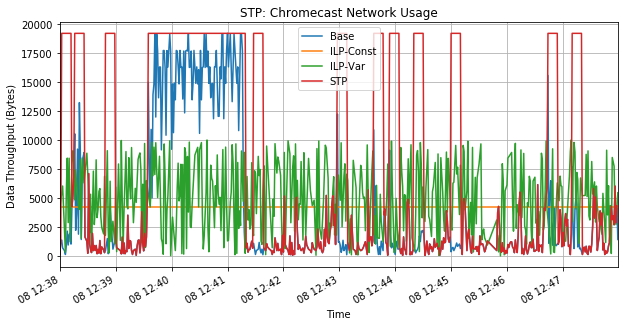

In [57]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
ax = chromecast_ilp_const_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Const: Chromecast Network Usage', figsize=(10,5), ax=ax)
ax = chromecast_ilp_var_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Variable: Chromecast Network Usage', figsize=(10,5), ax=ax)
chromecast_stp_df.plot(x='Time', y='Size', kind='line', grid=True, title='STP: Chromecast Network Usage', figsize=(10,5), ax=ax)
plt.legend(['Base', 'ILP-Const', 'ILP-Var', 'STP'])
plt.show()